GMU Simluation
==============

This python notebook simulates the GMU oracle given 12 months of bitcoin's price.

## Making the Indicator

We make the indicator using two TWAP to determine the price movement.

A 7 day TWAP (`MOVING_AVERAGE_SHORT_DURATION`) is used to stop the price appreciation whenever there is an decrease in price.

A 30 day TWAP (`MOVING_AVERAGE_LONG_DURATION`) is used to used to measure the price appreciation whenever this is an increase in price.

Furthermore a `DAMPENING_FACTOR` is applied to dampen the appreciation of the indicator wrt to the appreciation of the underlying. If we want the indicator to appreciate at a rate of 10% of the appreciation of the underlying, then we set the `DAMPENING_FACTOR` to `0.1`

Whenever the 7 day and 30 day TWAPs are in an upward trend, we appreciate the indicator by 10% of the appreciation of the 30 day TWAP. In all other cases we don't do anything.

---

## Simluation Results

Below we simulate the simple indicator with a starting index of 2 and taking in Bitcoin's daily price from Oct 2020 to Feb 2022 (Roughly 12 months of data). We make the following observations from the graphs below

- The indicator succesfully appreciates in a bull market but remains stable in a bear market.
- The indicator ends at a value of 2.34 which is roughly a 17% appreciation over 12 months

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# fetch the last few prices of bitcoin
bitcoinPrice = pd.read_csv('bitcoin_price.csv')

# The dampening factor determines how much we will appreciate ARTH by based on the 
# growth of ETH & BTC. In this case it is roughly 10%
DAMPENING_FACTOR = 0.1

MOVING_AVERAGE_LONG_DURATION = 30
MOVING_AVERAGE_SHORT_DURATION = 7

Text(0.5, 1.0, 'Bitcoin price: Oct 2020 - Feb 2022')

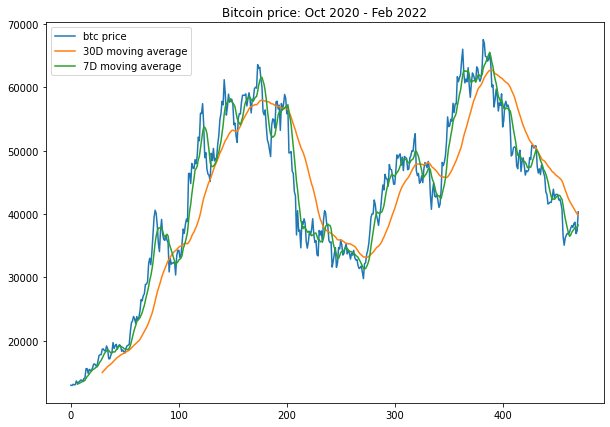

In [54]:
bitcoinPrice['30d_ma'] = bitcoinPrice['close'].rolling(MOVING_AVERAGE_LONG_DURATION).mean()
bitcoinPrice['7d_ma'] = bitcoinPrice['close'].rolling(MOVING_AVERAGE_SHORT_DURATION).mean()

plt.figure(figsize=(10, 7))

plt.plot(bitcoinPrice['close'])
plt.plot(bitcoinPrice['30d_ma'])
plt.plot(bitcoinPrice['7d_ma'])

plt.legend(['btc price', '30D moving average', '7D moving average'])
plt.title("Bitcoin price: Oct 2020 - Feb 2022")

From the above chart we can see that the 30 day and 7 day moving averages are smooth enough trends for us to capture the long-term and short-term price action of Bitcoin.

Text(0.5, 1.0, 'slope of 30d & 7d moving averages')

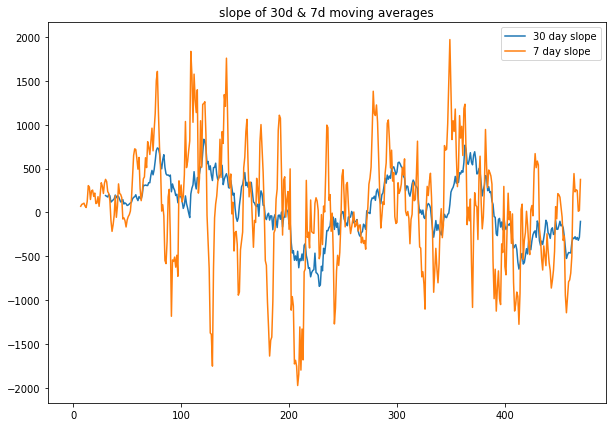

In [55]:
# calculate the slope of each pt/day
def get_slope_trend (data):
  dailyPriceDelta = [0]
  for i in range(len(bitcoinPrice.index)):
    if i!= 0:
      diff = (bitcoinPrice.loc[i, data] - bitcoinPrice.loc[i - 1, data])
      dailyPriceDelta.append(diff)
  return dailyPriceDelta  

bitcoinPrice['slope_30d'] = get_slope_trend('30d_ma')
bitcoinPrice['slope_7d'] = get_slope_trend('7d_ma')

plt.figure(figsize=(10, 7))
plt.plot(bitcoinPrice['slope_30d'])
plt.plot(bitcoinPrice['slope_7d'])

plt.legend(['30 day slope', '7 day slope'])
plt.title("slope of 30d & 7d moving averages")

From the above chart we can see that the 30 day moving average fluctuates a lot lesser than then 7 day moving average.

In [56]:
price30d = np.array(bitcoinPrice['30d_ma'])
price7d = np.array(bitcoinPrice['7d_ma'])
trend = [2] * MOVING_AVERAGE_LONG_DURATION

# Ptn will help us attain the memory part of thresholds
# assuming we start in the middle region
for i in range(MOVING_AVERAGE_LONG_DURATION, len(price30d)):
  # If we are going to change the price, check if both the 30d and 7d price are
  # appreciating
  if (price30d[i] > price30d[i - 1] and price7d[i] > price7d[i - 1]):
    delta = price30d[i] - price30d[i - 1]
    percentageChange = delta / price30d[i - 1] 

    # dampen the change; say we will only appreciate ARTH by 10% of the bitcoin appreciation
    dampnedChange = percentageChange * DAMPENING_FACTOR
    trend.append(trend[i -1] * (1 + dampnedChange))

  # dont' change the price
  else:
    trend.append(trend[i - 1])

bitcoinPrice['trend'] = trend
bitcoinPrice[MOVING_AVERAGE_LONG_DURATION:]


,date,open,high,low,close,volume,sma_30,30d_ma,7d_ma,slope_30d,slope_7d,trend
30,2020-11-21,18655.66,18965.90,18308.58,18703.80,75577.458394,15167.605667,15167.605667,17609.765714,191.176000,376.192857,2.002553
31,2020-11-22,18703.80,18750.00,17610.86,18414.43,81645.737778,15350.651000,15350.651000,17960.827143,183.045333,351.061429,2.004970
32,2020-11-23,18413.88,18766.00,18000.00,18368.00,82961.506093,15525.860000,15525.860000,18197.174286,175.209000,236.347143,2.007258
33,2020-11-24,18368.01,19418.97,18018.00,19160.01,113581.509241,15730.232667,15730.232667,18411.550000,204.372667,214.375714,2.009900
34,2020-11-25,19160.00,19484.21,18500.27,18719.11,93266.576887,15919.130000,15919.130000,18546.262857,188.897333,134.712857,2.012314
...,...,...,...,...,...,...,...,...,...,...,...,...
466,2022-01-31,37881.75,38744.00,36632.61,38466.90,36855.245800,40863.838000,40863.838000,37594.260000,-308.525000,258.078571,2.342422
467,2022-02-01,38466.90,39265.20,38000.00,38694.59,34574.446630,40577.451667,40577.451667,37842.298571,-286.386333,248.038571,2.342422
468,2022-02-02,38694.59,38855.92,36586.95,36896.36,35794.681300,40259.127000,40259.127000,37854.730000,-318.324667,12.431429,2.342422
469,2022-02-03,36896.37,37387.00,36250.00,37311.61,32081.109990,39975.113667,39975.113667,37876.374286,-284.013333,21.644286,2.342422


With the above algorithim, we feed in the 30-day and 7-day moving averages and come up with the final trendline which starts at 2 and ends at 2.34 which is roughly a 17% increase from the very beginning.

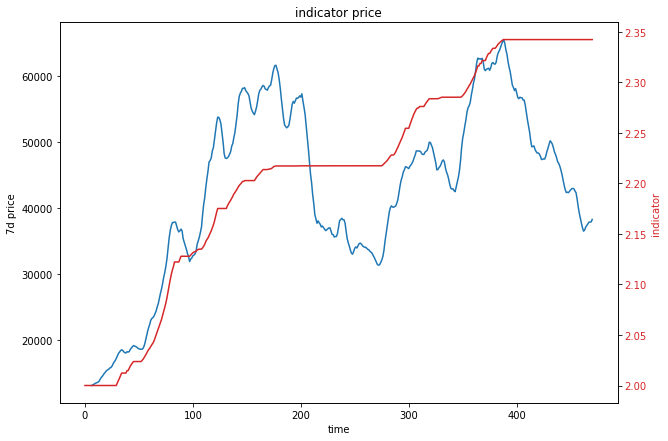

In [57]:
# Plot the data

fig, ax1 = plt.subplots()

plt.title("indicator price")
fig.set_figwidth(10)
fig.set_figheight(7)

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('7d price')
ax1.plot(bitcoinPrice['7d_ma'])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('indicator', color=color)
ax2.plot(bitcoinPrice['trend'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [58]:
df = pd.DataFrame()
df['date'] = bitcoinPrice['date']
df['price'] = bitcoinPrice['close']
df['7d moving average'] = bitcoinPrice['7d_ma']
df['30d moving average'] = bitcoinPrice['30d_ma']
df['indicator'] = bitcoinPrice['trend']

df[MOVING_AVERAGE_LONG_DURATION:]

,date,price,7d moving average,30d moving average,indicator
30,2020-11-21,18703.80,17609.765714,15167.605667,2.002553
31,2020-11-22,18414.43,17960.827143,15350.651000,2.004970
32,2020-11-23,18368.00,18197.174286,15525.860000,2.007258
33,2020-11-24,19160.01,18411.550000,15730.232667,2.009900
34,2020-11-25,18719.11,18546.262857,15919.130000,2.012314
...,...,...,...,...,...
466,2022-01-31,38466.90,37594.260000,40863.838000,2.342422
467,2022-02-01,38694.59,37842.298571,40577.451667,2.342422
468,2022-02-02,36896.36,37854.730000,40259.127000,2.342422
469,2022-02-03,37311.61,37876.374286,39975.113667,2.342422
